In [85]:
import tensorflow as tf
from keras import layers, models
import math

In [86]:
#------------------------------------------------------
# Python imports and environment setup
#------------------------------------------------------
# opencv
import cv2
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import os
import os

# import glob
import glob

# import random
import random

# import pickle
import pickle

# tensorflow
import tensorflow as tf

# pandas
import pandas as pd

In [ ]:
import cv2
import numpy as np

# Define the path to the images and annotations
img_path = "/path/to/images"
anno_path = "/path/to/annotations"

# Define the input image size for YOLO
input_size = (416, 416)

# Define the number of classes
num_classes = 2

# Define the anchor boxes for the YOLO model
anchors = [(10,13), (16,30), (33,23), (30,61), (62,45), (59,119), (116,90), (156,198), (373,326)]

# Load the annotations
with open(anno_path, "r") as f:
    annotations = f.readlines()

# Loop over all annotations
for anno in annotations:
    # Split the annotation string into separate values
    anno_values = anno.split(" ")
    
    # Get the image filename and path
    img_name = anno_values[0]
    img_file = img_path + "/" + img_name
    
    # Load the image
    img = cv2.imread(img_file)
    
    # Get the image dimensions
    height, width, channels = img.shape
    
    # Get the number of bounding boxes in the annotation
    num_boxes = (len(anno_values) - 1) // 5
    
    # Create empty arrays to store the bounding box coordinates and class labels
    bbox_coords = np.zeros((num_boxes, 4))
    bbox_classes = np.zeros((num_boxes, num_classes))
    
    # Loop over all bounding boxes in the annotation
    for i in range(num_boxes):
        # Get the coordinates of the bounding box
        x_center = float(anno_values[1 + 5*i])
        y_center = float(anno_values[2 + 5*i])
        bbox_width = float(anno_values[3 + 5*i])
        bbox_height = float(anno_values[4 + 5*i])
        
        # Convert the YOLO format coordinates to pixel coordinates
        x_min = int((x_center - bbox_width/2) * width)
        y_min = int((y_center - bbox_height/2) * height)
        x_max = int((x_center + bbox_width/2) * width)
        y_max = int((y_center + bbox_height/2) * height)
        
        # Store the bounding box coordinates
        bbox_coords[i] = [x_min, y_min, x_max, y_max]
        
        # Get the class label of the bounding box
        bbox_class = int(anno_values[5 + 5*i])
        
        # Store the class label as a one-hot vector
        bbox_classes[i][bbox_class] = 1
        
    # Resize the image to the input size for YOLO
    resized_img = cv2.resize(img, input_size)
    
    # Normalize the image pixel values to the range [0, 1]
    normalized_img = resized_img / 255.0
    
    # Convert the bounding box coordinates to YOLO format
    yolo_boxes = np.zeros((num_boxes, 5))
    yolo_boxes[:,:4] = bbox_coords / input_size[0]
    yolo_boxes[:,4] = bbox_classes[:,0] # In this example, we assume that the first class is the target object
    
    # Apply the YOLO anchor boxes
    yolo_boxes = apply_anchor_boxes(yolo_boxes, anchors)
    
    # Save the preprocessed image and annotations
    cv2.imwrite


# fddb

In [ ]:
from PIL import Image  
import pickle
import os
import numpy as np
import cv2
import glob

In [ ]:
ANCHOR_SIZE = 4
IMG_SIZE = 128
BATCH_SIZE = 32

In [ ]:
def iou(boxA, boxB):
  #evaluate the intersection points 
  xA = np.maximum(boxA[0], boxB[0])
  yA = np.maximum(boxA[1], boxB[1])
  xB = np.minimum(boxA[2], boxB[2])
  yB = np.minimum(boxA[3], boxB[3])

  # compute the area of intersection rectangle
  interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)

  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

  #compute the union 
  unionArea = (boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return interArea / unionArea

#for a given box we predict the corrosponding bounding box 
def get_anchor(box):

  max_iou = 0.0 
  
  matching_anchor  = [0, 0, 0, 0]
  matching_index   = (0, 0)
  i = 0 
  j = 0 
  
  w , h = (1/ANCHOR_SIZE, 1/ANCHOR_SIZE)
  
  for x in np.linspace(0, 1, ANCHOR_SIZE +1)[:-1]:
    j = 0 
    for y in np.linspace(0, 1, ANCHOR_SIZE +1)[:-1]:
      xmin = x 
      ymin = y
      
      xmax = (x + w) 
      ymax = (y + h) 
      
      anchor_box = [xmin, ymin, xmax, ymax]
      curr_iou = iou(box, anchor_box)
      
      #choose the location with the highest overlap 
      if curr_iou > max_iou:
        matching_anchor = anchor_box
        max_iou = curr_iou
        matching_index = (i, j)
      j += 1
    i+= 1
  return matching_anchor, matching_index

In [ ]:
def create_volume(boxes):
  output = np.zeros((ANCHOR_SIZE, ANCHOR_SIZE, 5))
  for box in boxes:
    if max(box) == 0:
      continue
    _, (i, j) = get_anchor(box)
    output[i,j, :] = [1] + box
  return output

In [ ]:
#read all the files for annotation 
annot_files = glob.glob('data/FDDB/FDDB-folds/*ellipseList.txt')
data = {}
for file in annot_files:  
  with open(file, 'r') as f:
    rows = f.readlines()
    
  j = len(rows)
  i = 0   
  while(i < j):
    #get the file name
    file_name = rows[i].replace('\n', '')+'.jpg'
    
    #get the number of boxes 
    num_boxes = int(rows[i+1])
    boxes = []
    file_name = 'data/FDDB/originalPics/'+file_name
    img = Image.open(file_name)
    w, h = img.size
    #get all the bounding boxes
    for k in range(1, num_boxes+1):
      box = rows[i+1+k]
      box = box.split(' ')[0:5]
      box = [float(x) for x in box]
      
      #convert ellipse to a box 
      xmin = int(box[3]- box[1])
      ymin = int(box[4]- box[0])
      xmax = int(xmin + box[1]*2)
      ymax = int(ymin + box[0]*2)
      boxes.append([xmin/w, ymin/h, xmax/w, ymax/h])
    #conver the boxes to a volume of fixed size 
    data[file_name] = create_volume(boxes)
    i = i + num_boxes+2

In [ ]:
def parse_training(filename, label):
  
  image = tf.image.decode_jpeg(tf.io.read_file(filename), channels = 3)
  
  image = tf.image.convert_image_dtype(image, tf.float32)
    
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  
  label = tf.cast(label, tf.float32)
  return image, label

def parse_testing(filename, label):
  
  image = tf.image.decode_jpeg(tf.io.read_file(filename), channels = 3)
  
  image = tf.image.convert_image_dtype(image, tf.float32)
  
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  
  label = tf.cast(label, tf.float32)
  return image, label

def create_dataset(ff, ll, training = True):

  dataset = tf.data.Dataset.from_tensor_slices((ff, ll)).shuffle(len(ff) - 1)
  if training:
    dataset = dataset.map(parse_training, num_parallel_calls = 4)
  else:
    dataset = dataset.map(parse_testing, num_parallel_calls = 4)
  dataset = dataset.batch(BATCH_SIZE)
  
  return dataset

In [ ]:
files = list(data.keys())
labels = list(data.values())

N = len(files)
M = int(0.9 * N)

#split files for images 
train_files = files[:M]
test_files  = files[M:]

#split labels
train_labels = labels[:M]
test_labels =  labels[M:]

In [ ]:
print('training', len(train_files))
print('testing' , len(test_files))

training 2560
testing 285


In [ ]:


train_dataset = create_dataset(train_files, train_labels)
test_dataset = create_dataset(test_files, test_labels, training = False)

In [ ]:
def plot_annot(img, boxes):  

  img = img.numpy()
  boxes = boxes.numpy() 
  
  for i in range(0, ANCHOR_SIZE):
    for j in range(0, ANCHOR_SIZE):
      box = boxes[i, j, 1:] * IMG_SIZE
      label = boxes[i, j, 0]
      
      if np.max(box) > 0:
        img = cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (1, 0, 0), 1)

  plt.axis('off')
  plt.imshow(img)
  plt.show()

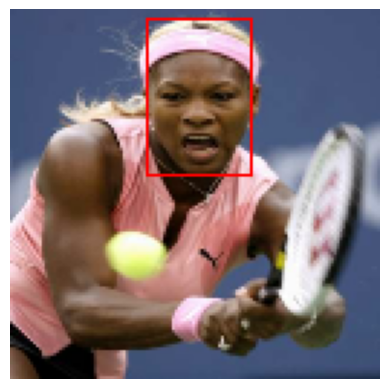

In [ ]:
for x, y in train_dataset:
  plot_annot(x[0], y[0])
  break

# wider face

In [ ]:
# Define the path to the WIDER Face dataset
dataset_path = 'data/WIDERFace'

# Load the train/test/val image names and annotation files
train_file = os.path.join(dataset_path, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
test_file = os.path.join(dataset_path, 'wider_face_split', 'wider_face_test_filelist.txt')
val_file = os.path.join(dataset_path, 'wider_face_split', 'wider_face_val_bbx_gt.txt')
train_images_path = os.path.join(dataset_path, 'WIDER_train')
test_images_path = os.path.join(dataset_path, 'WIDER_test')
val_images_path = os.path.join(dataset_path, 'WIDER_val')

# Training
TRAIN_WIDER_PATH = "data/WIDERFace/WIDER_train/"

# Validation
VAL_WIDER_PATH = "data/WIDERFace/WIDER_val/"

# Testing
TEST_WIDER_PATH = "data/WIDERFace/WIDER_test/"

# Ground Truth
GROUND_TRUTH_PATH = "data/WIDERFace/wider_face_split/"

# Output
OUTPUT_PATH = "data/WIDERFace/output/"

In [ ]:

import tensorflow as tf
import numpy as np
import cv2
import os
import hashlib
import matplotlib.pyplot as plt
import json

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [ ]:
train_images = tf.data.Dataset.list_files('data/custom/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (224,224)))
train_images = train_images.map(lambda x: x/255)

train_labels = tf.data.Dataset.list_files('data/custom/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.string, tf.float32]))

train_dataset = tf.data.Dataset.zip((train_images, train_labels))
train_dataset = train_dataset.batch(32)

val_images = tf.data.Dataset.list_files('data/custom/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (224,224)))
val_images = val_images.map(lambda x: x/255)

val_labels = tf.data.Dataset.list_files('data/custom/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.string, tf.float32]))

val_dataset = tf.data.Dataset.zip((val_images, val_labels))
val_dataset = val_dataset.batch(32)

test_images = tf.data.Dataset.list_files('data/custom/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (224,224)))
test_images = test_images.map(lambda x: x/255)

test_labels = tf.data.Dataset.list_files('data/custom/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.string, tf.float32]))

test_dataset = tf.data.Dataset.zip((test_images, test_labels))
test_dataset = test_dataset.batch(32)

#------------------------------------------------------



In [ ]:
base_dir = "data/WIDERFace"
     

train_path = os.path.join(base_dir,"WIDER_train")
val_path = os.path.join(base_dir,"WIDER_val")
test_path = os.path.join(base_dir,"WIDER_test")
     

train_images=[]
for directory in os.listdir(train_path):
  sub_directory = os.path.join(train_path,directory)
  train_images.extend(os.listdir(sub_directory))

print("Found {} images for training.".format(len(train_images)))

train_images[:5]

val_images=[]
for directory in os.listdir(val_path):
  sub_directory = os.path.join(val_path,directory)
  val_images.extend(os.listdir(sub_directory))

print("Found {} images for validating.".format(len(val_images)))

print(val_images[:5])

test_images=[]
for directory in os.listdir(test_path):
    sub_directory = os.path.join(test_path,directory)
    test_images.extend(os.listdir(sub_directory))

print("Found {} images for testing.".format(len(test_images)))

annotation_path = os.path.join(base_dir,"wider_face_split")
val_annotation_path = os.path.join(annotation_path,"wider_face_val_bbx_gt.txt")
train_annotation_path = os.path.join(annotation_path,"wider_face_train_bbx_gt.txt")
test_annotation_path = os.path.join(annotation_path,"wider_face_test_filelist.txt")
     

train_annot = []
with open(train_annotation_path) as f:
  for j in range(len(train_images)):
    dir,name = f.readline().split('/')
    dir = dir.split('__')[0]
    dir = os.path.join(train_path,dir)    
    n = int(f.readline().rstrip())
    co_ords=[]
    if n==0:
      co_ord = f.readline().split()
      co_ords.append(co_ord)
    else:
      for i in range(n):
        co_ord = f.readline().split()
        co_ords.append(co_ord)
    train_annot.append({'image':name,'n':n,'co_ords':co_ords, 'path' : dir })

val_annot = []
with open(val_annotation_path) as f:
  for j in range(len(val_images)):
    dir,name = f.readline().split('/')
    dir = dir.split('__')[0]
    dir = os.path.join(val_path,dir)    
    n = int(f.readline().rstrip())
    co_ords=[]
    if n==0:
      co_ord = f.readline().split()
      co_ords.append(co_ord)
    else:
      for i in range(n):
        co_ord = f.readline().split()
        co_ords.append(co_ord)
    val_annot.append({'image':name,'n':n,'co_ords':co_ords, 'path' : dir })




print("catalogued {} images".format(len(train_annot)))
print("catalogued {} images".format(len(val_annot)))


Found 12880 images for training.
Found 3226 images for validating.
['0_Parade_marchingband_1_1004.jpg', '0_Parade_marchingband_1_104.jpg', '0_Parade_marchingband_1_1045.jpg', '0_Parade_marchingband_1_139.jpg', '0_Parade_marchingband_1_147.jpg']
Found 16097 images for testing.
catalogued 12880 images
catalogued 3226 images


In [ ]:
train_file = os.path.join(dataset_path, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
with open(train_file, 'r') as f:
    lines = f.readlines()

train_data = {}
for i in range(0, len(lines), 2):
    filename = lines[i].strip()
    num_faces = int(lines[i+1].strip())
    if num_faces == 0:
        continue
    boxes = []
    for j in range(num_faces):
        bbox = lines[i+2+j].strip().split()
        x, y, w, h = map(int, bbox)
        boxes.append([x, y, x+w, y+h])
    train_data[filename] = np.array(boxes)


# model


In [ ]:
import tensorflow as tf

def create_face_detection_model(input_shape):
    model = tf.keras.Sequential([
        # Convolutional layers
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        # Flatten and fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='sigmoid') # output layer with two nodes for binary classification
    ])
    return model


In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3

num_anchors = 9

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate

# Input tensor
input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# Base network (VGG16)
conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(input_tensor)
conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(conv1_1)
pool1 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)

conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(pool1)
conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(conv2_1)
pool2 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)

conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(pool2)
conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(conv3_1)
conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(conv3_2)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)

conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(pool3)
conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(conv4_1)
conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(conv4_2)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)

conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(pool4)
conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(conv5_1)
conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(conv5_2)
pool5 = MaxPooling2D((3, 3), strides=(1, 1), padding='same', name='pool5')(conv5_3)

# Additional convolutional layers
fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', name='fc6')(pool5)
fc7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name='fc7')(fc6)

# Classification head
num_classes = 2  # number of object classes (e.g., person, car, etc.)
cls_conv1 = Conv2D(256, (1, 1), activation='relu', padding='same')(fc7)
cls_conv2 = Conv2D(256, (1, 1), activation='relu', padding='same')(cls_conv1)
cls_conv3 = Conv2D(256, (1, 1), activation='relu', padding='same')(cls_conv2)
cls_conv4 = Conv2D(256, (1, 1), activation='relu', padding='same')(cls_conv3)
cls_flat = Flatten()(cls_conv4)
cls_fc1 = Dense(512, activation='relu')(cls_flat)
cls_fc2 = Dense(num_classes * num_anchors, activation='softmax')(cls_fc1)
cls_out = Reshape((num_anchors, num_classes))(cls_fc2)

# Regression head
box_conv1 = Conv2D(256, (1, 1), activation='relu', padding='same')(fc7)
box_conv2 = Conv2D(256, (1, 1), activation='relu', padding='same')(box_conv1)
box_conv3 = Conv2D(256, (1, 1), activation='relu', padding='same')(box_conv2)
box_conv4 = Conv2D(256, (1, 1), activation='relu', padding='same')(box_conv3)
box_flat = Flatten()(box_conv4)
box_fc1 = Dense(512, activation='relu')(box_flat)
box_fc2 = Dense(num_anchors * 4, activation='linear')(box_fc1)
box_out = Reshape((num_anchors, 4))(box_fc2)

# Concatenate classification and regression outputs
output = Concatenate(axis=2)([box_out, cls_out])

# Create SSD model
model = Model(inputs=inputs, outputs=output)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Reshape, Activation, Concatenate
from tensorflow.keras.models import Model

# Define the input shape for the model
input_shape = (300, 300, 3)

# Define the input layer
input_layer = Input(shape=input_shape)

# Define the VGG16 base network
vgg16_conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(input_layer)
vgg16_conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(vgg16_conv1_1)
pool1 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(vgg16_conv1_2)

vgg16_conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(pool1)
vgg16_conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(vgg16_conv2_1)
pool2 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(vgg16_conv2_2)

vgg16_conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(pool2)
vgg16_conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(vgg16_conv3_1)
vgg16_conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(vgg16_conv3_2)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(vgg16_conv3_3)

vgg16_conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(pool3)
vgg16_conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(vgg16_conv4_1)
vgg16_conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(vgg16_conv4_2)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(vgg16_conv4_3)

vgg16_conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(pool4)
vgg16_conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(vgg16_conv5_1)
vgg16_conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(vgg16_conv5_2)
pool5 = MaxPooling2D((3, 3), strides=(1, 1), padding='same', name='pool5')(vgg16_conv5_3)

# Additional convolutional layers
fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', name='fc6')(pool5)
fc7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name='fc7')(fc6)

# Classification head
num_classes = 2  # number of object classes (e.g., person, car, etc.)
cls_conv1 = Conv2D(256, (1, 1), activation='relu', padding='same')(fc7)
cls_conv2 = Conv2D(256, (1, 1), activation='relu', padding='same')(cls_conv1)
cls_conv3 = Conv2D(256, (1, 1), activation='relu', padding='same')(cls_conv2)
cls_conv4 = Conv2D(256, (1, 1), activation='relu', padding='same')(cls_conv3)
cls_flat = Flatten()(cls_conv4)

# Regression head
box_conv1 = Conv2D(256, (1, 1), activation='relu', padding='same')(fc7)
box_conv2 = Conv2D(256, (1, 1), activation='relu', padding='same')(box_conv1)
box_conv3 = Conv2D(256, (1, 1), activation='relu', padding='same')(box_conv2)
box_conv4 = Conv2D(256, (1, 1), activation='relu', padding='same')(box_conv3)
box_flat = Flatten()(box_conv4)

# Concatenate classification and regression outputs
output = Concatenate(axis=1)([box_flat, cls_flat])

# Create SSD model
model = Model(inputs=input_layer, outputs=output)



# TRAINING

In [ ]:
epochs = 20

#initialize the history to record the metrics 
train_loss_history = tf.metrics.Mean('train_loss')

test_loss_history = tf.metrics.Mean('test_loss')

best_loss = 0.0 

In [ ]:
# Define the model
model = create_face_detection_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.applications import mobilenet_v2
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.backend import epsilon
import time


# Print the model summary
model.summary()

train_loss_history = tf.keras.metrics.Mean()
test_loss_history = tf.keras.metrics.Mean()
accuracy = tf.keras.metrics.Accuracy()

for i in range(1, epochs + 1):
  
  # record start time of epoch
  start_time = time.time()

  for x, y in train_dataset:
    pred = model(x)
    grads = grad(model, x, y)

    #update the paramters of the model 
    optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step = tf.compat.v1.train.get_or_create_global_step())

    #record the metrics of the current batch 
    loss_value = loss(pred, y)
    
    #calcualte the metrics of the current batch
    train_loss_history(loss_value)
    
  #loop over the test dataset 
  for x, y in test_dataset:
    pred = model(x)
    
    #calcualte the metrics of the current batch 
    loss_value = loss(pred, y)
    
    #record the values of the metrics 
    test_loss_history(loss_value)
        
  # record end time of epoch
  end_time = time.time()
  
  # calculate time taken for epoch
  epoch_time = end_time - start_time

  accuracy.reset_states()
  for x, y in test_dataset:
    pred = model(x)
    accuracy.update_state(tf.argmax(y, axis=1), tf.argmax(pred, axis=1))
  
#print out the results with accuracy and time taken
  print("epoch: [{0:d}/{1:d}], Train: [loss: {2:0.4f}], Test: [loss: {3:0.4f}], Accuracy: {4:.2f}%, Time: {5:.2f}s".
       format(i, epochs, train_loss_history.result(), 
              test_loss_history.result(), accuracy.result() * 100, epoch_time))
  
  current_loss = test_loss_history.result().numpy()
  
  #save the best model 
  if current_loss  < best_loss:
    best_loss = current_loss
    print('saving best model with loss ', current_loss)
    model.save('model.h5')
    
  #clear the history after each epoch 
  train_loss_history = tf.keras.metrics.Mean()
  test_loss_history = tf.keras.metrics.Mean()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 16, 16, 128)     

ValueError: Shapes (32, 2) and (32, 4, 4) are incompatible

# SCORES

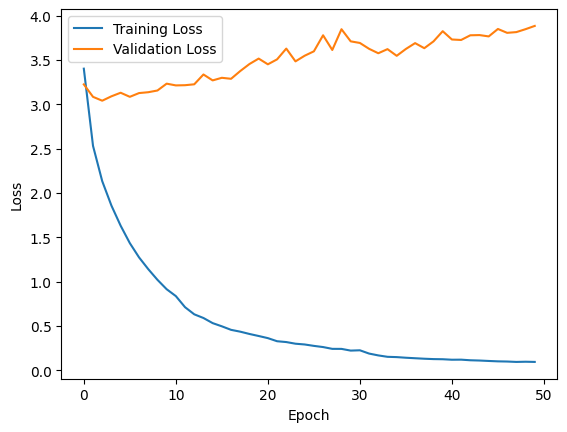

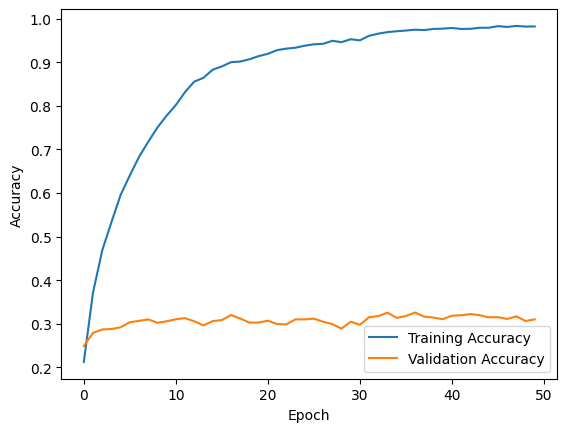

In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy from history.history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss over the epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over the epochs
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# load model

In [ ]:
from keras.models import load_model
best_model = load_model('model.h5')
#visualize the predicted bounding box
def plot_pred(img_id):
  font = cv2.FONT_HERSHEY_SIMPLEX

  raw = cv2.imread(img_id)[:,:,::-1]
  
  h, w = (512, 512)
  
  img = cv2.resize(raw, (IMG_SIZE, IMG_SIZE)).astype('float32')
  img = np.expand_dims(img, 0)/255. 
  
  boxes = best_model(img).numpy()[0]

  raw = cv2.resize(raw, (w, h))
    
  for i in range(0, ANCHOR_SIZE):
    for j in range(0, ANCHOR_SIZE):
      box = boxes[i, j, 1:] * w
      lbl = round(boxes[i, j, 0], 2)
      if lbl > 0.5:
        color = [random.randint(0, 255) for _ in range(0, 3)]
        raw = cv2.rectangle(raw, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 3) 
        raw = cv2.rectangle(raw, (int(box[0]), int(box[1])-30), (int(box[0])+70, int(box[1])), color, cv2.FILLED)
        raw = cv2.putText(raw, str(lbl), (int(box[0]), int(box[1])), font, 1, (255, 255, 255), 2)
        

  plt.axis('off')
  plt.imshow(raw)
  plt.show()

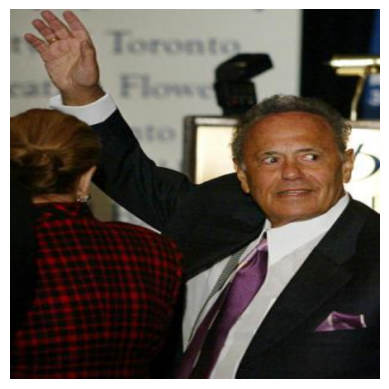

In [ ]:
img_id = np.random.choice(test_files)
plot_pred(img_id)